# **Machine Learning Projekt**
In this notebook we perform Deep Learning Image Classification on the [Kaggle Forest Fire Images Data Set](https://www.kaggle.com/datasets/mohnishsaiprasad/forest-fire-images).
We train a Convolutional NN and optimize its F1 Score.
We also utilize Data Augmentation, Dropout and the Keras-Tuner Framework to optimize our Model.

The notebook is structured as follows:
1. Import and Data Load
2. Modelling 
3. Evaluation 


# 1. Imports and Data Load

In [1]:
#limit usage of GPUs to one Device 
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

#more imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import re

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

### Load Data with Keras
Before loading we removed 389 files from the directory, because they were empty file.
We also removed 375 because they were wrongly labeled.

In [2]:
#configure size of batch and image size
batch_size = 32
img_height = 180
img_width = 180

In [3]:
#directories
dir_train = "../Data/Dataset_split/train"
dir_val = "../Data/Dataset_split/val"
dir_test = "../Data/Dataset_split/test"

In [4]:
#Generates a tf.data.Dataset from image files in the directory.
train_ds = tf.keras.utils.image_dataset_from_directory(
  dir_train,
  seed=88212,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3662 files belonging to 2 classes.


2022-05-29 16:54:31.469304: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-29 16:54:32.172482: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9646 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1d:00.0, compute capability: 7.5


In [5]:
#Generates a tf.data.Dataset from image files in the directory.
val_ds = tf.keras.utils.image_dataset_from_directory(
  dir_val,
  seed=88212,
  labels = "inferred",
  label_mode= "binary",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 456 files belonging to 2 classes.


In [6]:
#Generates a tf.data.Dataset from image files in the directory.
test_ds = tf.keras.utils.image_dataset_from_directory(
  dir_test,
  seed=88212,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 460 files belonging to 2 classes.


In [7]:
class_names = train_ds.class_names
print(class_names)

['Data_Fire', 'Data_NonFire']


In [38]:
import pathlib
data_dir = pathlib.Path("../Data/Dataset_split/train")
image_count = len(list(pathlib.Path("../Data/Dataset_split/train").glob('*/*.jpg')))+len(list(pathlib.Path("../Data/Dataset_split/test").glob('*/*.jpg')))+len(list(pathlib.Path("../Data/Dataset_split/val").glob('*/*.jpg')))
print("count total images: ", image_count)

count total images:  4578


**Images have standardized aspect ratio and size after load**

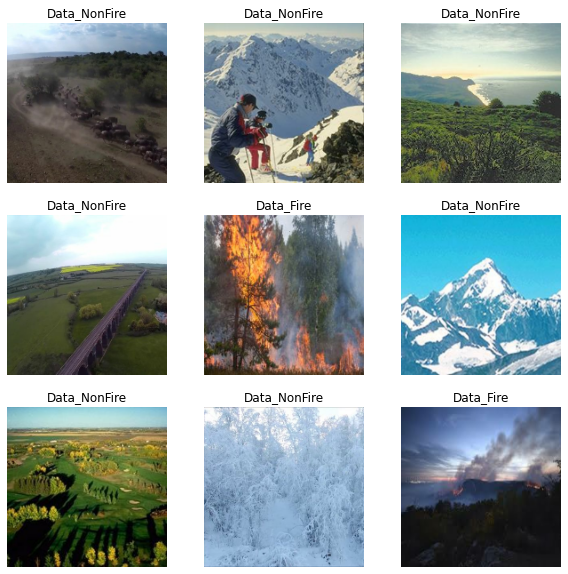

In [79]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [80]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


### Performance Optimization

Buffered prefetching so we can yield data from disk without having I/O becoming blocking:

In [46]:
#performance optimization
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Standardizing the data

The images have already been transformed to standard size (180x180) in the loading step. Their RGB channel values are still in the [0, 255] range, which is not ideal for neural networks: generally input values should be small. Therefore we will standardize the values to be in a range from [0, 1] by using a Rescaling layer at the start of our model.

In [47]:
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
normalization_layer = layers.Rescaling(1./255)

### Functions for Training

In [17]:
#plot train and eval by epochs
def plot_train_eval(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [18]:
#Model Evaluation with 
#source: https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# 2. Modelling 

## Model 1

In [50]:
num_classes = len(class_names)

model_1 = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [55]:
model_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [56]:
model_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 45, 45, 64)       

In [57]:
epochs=10
history = model_1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
115/115 [==============================] - 10s 29ms/step - loss: 0.3705 - accuracy: 0.8670 - val_loss: 0.1850 - val_accuracy: 0.9386
Epoch 2/10
115/115 [==============================] - 1s 12ms/step - loss: 0.1820 - accuracy: 0.9315 - val_loss: 0.2112 - val_accuracy: 0.9123
Epoch 3/10
115/115 [==============================] - 1s 12ms/step - loss: 0.1547 - accuracy: 0.9427 - val_loss: 0.2121 - val_accuracy: 0.9298
Epoch 4/10
115/115 [==============================] - 1s 12ms/step - loss: 0.1312 - accuracy: 0.9511 - val_loss: 0.1518 - val_accuracy: 0.9561
Epoch 5/10
115/115 [==============================] - 1s 12ms/step - loss: 0.1117 - accuracy: 0.9593 - val_loss: 0.1349 - val_accuracy: 0.9474
Epoch 6/10
115/115 [==============================] - 1s 12ms/step - loss: 0.0750 - accuracy: 0.9711 - val_loss: 0.1057 - val_accuracy: 0.9649
Epoch 7/10
115/115 [==============================] - 1s 12ms/step - loss: 0.0593 - accuracy: 0.9798 - val_loss: 0.1425 - val_accuracy: 0.956

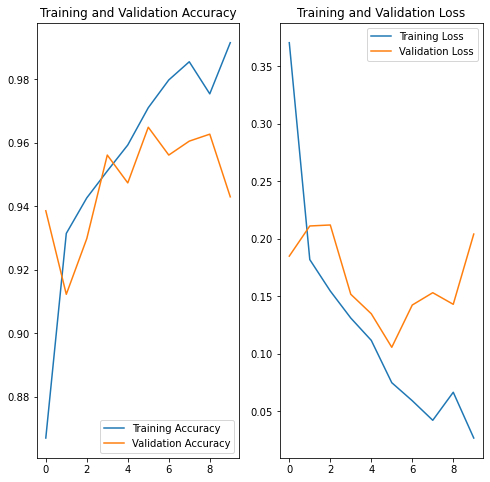

In [58]:
plot_train_eval(history)

In [59]:
#save model to disk
model_1.save('../Models/Model_1')

2022-05-29 16:21:49.010805: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../Models/Model_1/assets


## **Create an Image Data Augmentation Layer**
For the following models we extend our training set by implementing data augemenatation and regularize the model with dropout, in order to make it more robust.
To increase the size of our dataset, we artificially introduce sample diversity by applying random but realistic transformations to the original images. Namely these transformations can be random horizontal flippings, zooms or small random rotations.

In [9]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

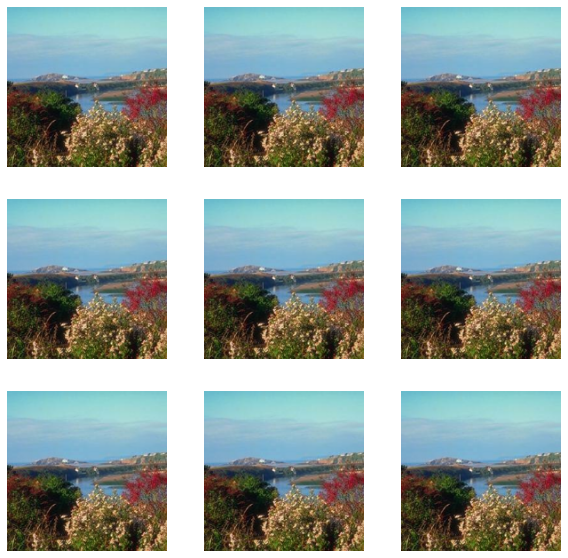

In [61]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Model 2
New Convolutinal NN with Dropout
[Named model_3 in code since model 2 has been removed.]

In [27]:
model_3 = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
  ])

In [28]:
model_3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc', tf.keras.metrics.AUC(), f1_m,precision_m, recall_m])

In [29]:
model_3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [30]:
epochs = 15
history = model_3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
115/115 [==============================] - 8s 60ms/step - loss: 0.2944 - acc: 0.8818 - auc_1: 0.9485 - f1_m: 0.8829 - precision_m: 0.8726 - recall_m: 0.9154 - val_loss: 0.1874 - val_acc: 0.9276 - val_auc_1: 0.9781 - val_f1_m: 0.9359 - val_precision_m: 0.9404 - val_recall_m: 0.9336
Epoch 2/15
115/115 [==============================] - 7s 54ms/step - loss: 0.2146 - acc: 0.9197 - auc_1: 0.9727 - f1_m: 0.9234 - precision_m: 0.9160 - recall_m: 0.9382 - val_loss: 0.1446 - val_acc: 0.9474 - val_auc_1: 0.9859 - val_f1_m: 0.9445 - val_precision_m: 0.9519 - val_recall_m: 0.9404
Epoch 3/15
115/115 [==============================] - 7s 54ms/step - loss: 0.1666 - acc: 0.9383 - auc_1: 0.9830 - f1_m: 0.9421 - precision_m: 0.9343 - recall_m: 0.9537 - val_loss: 0.1471 - val_acc: 0.9496 - val_auc_1: 0.9896 - val_f1_m: 0.9552 - val_precision_m: 0.9345 - val_recall_m: 0.9793
Epoch 4/15
115/115 [==============================] - 7s 54ms/step - loss: 0.1606 - acc: 0.9416 - auc_1: 0.9838 - f1_m: 0

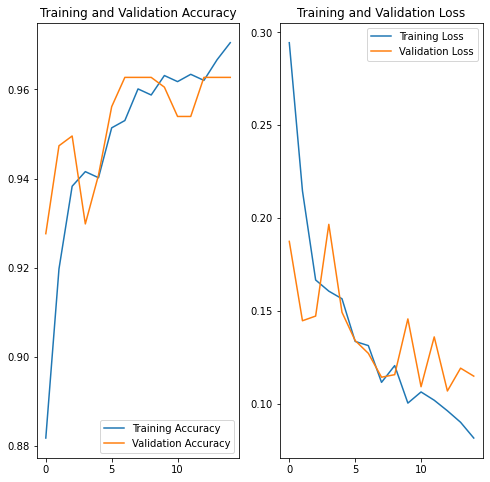

In [31]:
plot_train_eval(history)

Interestingly the validation Accuracy is sometimes higher than the Training Accuracy. This can happen when dropout is used.

In [32]:
# evaluate the model
loss, accuracy, auc, f1_score, precision, recall = model_3.evaluate(val_ds, verbose=0)
print(f"Validation on Validation Data:\nAccuracy: {round(accuracy,3)}\nAUC: {round(auc,3)}\nF1: {round(f1_score,3)}\nPrecision: {round(precision,3)}\nRecall:{round(recall,3)}")

Validation on Validation Data:
Accuracy: 0.963
AUC: 0.993
F1: 0.966
Precision: 0.949
Recall:0.985


In [33]:
#save model to disk
model_3.save('../Models/Model_3')

2022-05-29 17:24:00.275868: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../Models/Model_3/assets


## Hyperparametertuning
In this section we optimize our models hyperparameters on the F1-Score using the [Keras-Tuner Framework](https://keras.io/keras_tuner/).

In [22]:
#!pip install keras-tuner --upgrade
import keras_tuner as kt 

def build_model(hp):
    model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(hp.Choice('units', [32,64,128,264]), activation='relu'),
    layers.Dense(1, activation='sigmoid')
    ])
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['acc', tf.keras.metrics.AUC(), f1_m,precision_m, recall_m])   
    return model

tuner = kt.RandomSearch(
    build_model,
    seed = 88212,
    objective=kt.Objective("val_f1_m", direction="max"),
    max_trials=10,
    directory="../Models",
    #project_name ="/Random_Search_Results_2"
    )

tuner.search(train_ds, epochs=15, validation_data=(val_ds))

Trial 10 Complete [00h 01m 42s]
val_f1_m: 0.967040479183197

Best val_f1_m So Far: 0.9739522337913513
Total elapsed time: 00h 15m 23s
INFO:tensorflow:Oracle triggered exit


In [23]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, 28, 28))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                    

In [36]:
# evaluate the model
loss, accuracy, auc, f1_score, precision, recall = best_model.evaluate(val_ds, verbose=0)
print(f"Validation on Validation Data after Tuning:\nAccuracy: {round(accuracy,3)}\nAUC: {round(auc,3)}\nF1: {round(f1_score,3)}\nPrecision: {round(precision,3)}\nRecall:{round(recall,3)}")

Validation on Validation Data after Tuning:
Accuracy: 0.971
AUC: 0.989
F1: 0.973
Precision: 0.967
Recall:0.981


# Evaluation on Test-Dataset

**Visual Model Evaluation**
\
In this section, we evaluate the quality of the model by checking the inference on a preshuffeled range of images from the test-dataset.

--------------------------------  FIRE IMAGES  --------------------------------
This image is  99.92 percent Fire  and   0.08 percent Non Fire.


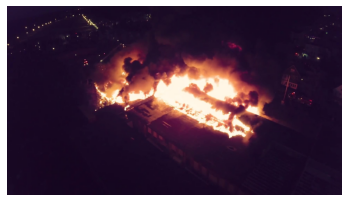

This image is  79.58 percent Fire  and   20.42 percent Non Fire.


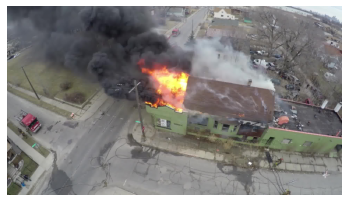

This image is  100.00 percent Fire  and   0.00 percent Non Fire.


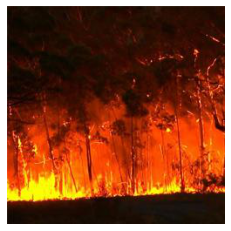

This image is  63.50 percent Fire  and   36.50 percent Non Fire.


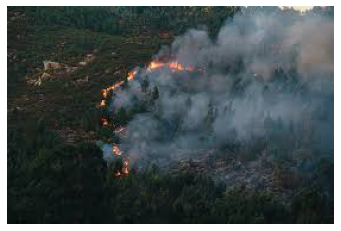

This image is  99.95 percent Fire  and   0.05 percent Non Fire.


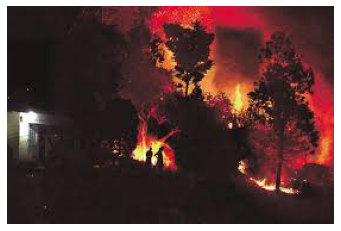

This image is  99.95 percent Fire  and   0.05 percent Non Fire.


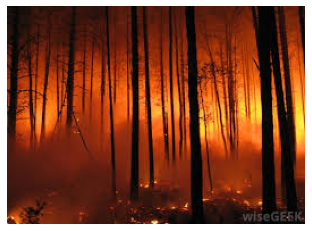

This image is  97.23 percent Fire  and   2.77 percent Non Fire.


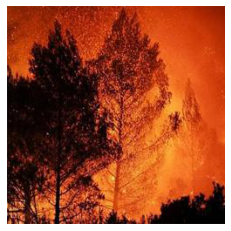

This image is  99.93 percent Fire  and   0.07 percent Non Fire.


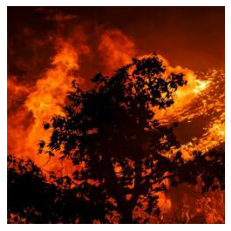

This image is  98.95 percent Fire  and   1.05 percent Non Fire.


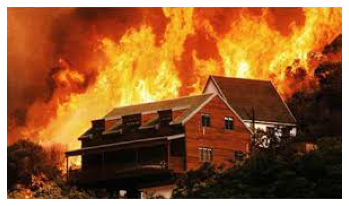

This image is  99.38 percent Fire  and   0.62 percent Non Fire.


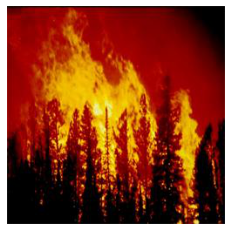

--------------------------------  NON FIRE IMAGES  --------------------------------
This image is  0.00 percent Fire  and   100.00 percent Non Fire.


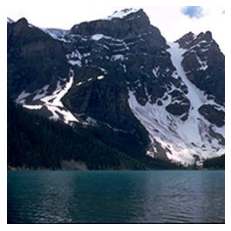

This image is  0.00 percent Fire  and   100.00 percent Non Fire.


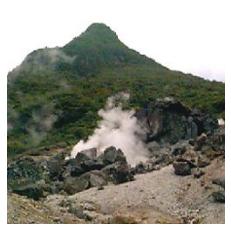

This image is  0.00 percent Fire  and   100.00 percent Non Fire.


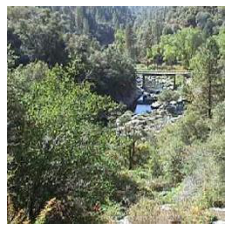

This image is  0.04 percent Fire  and   99.96 percent Non Fire.


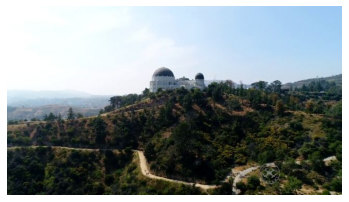

This image is  3.02 percent Fire  and   96.98 percent Non Fire.


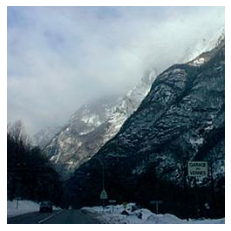

This image is  0.00 percent Fire  and   100.00 percent Non Fire.


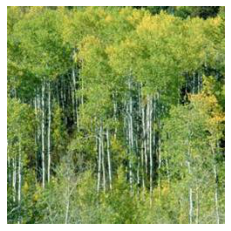

This image is  0.00 percent Fire  and   100.00 percent Non Fire.


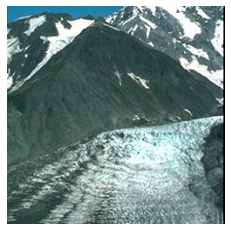

This image is  0.05 percent Fire  and   99.95 percent Non Fire.


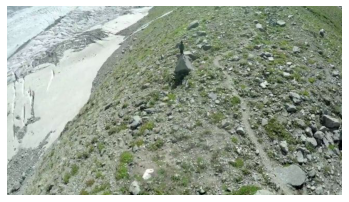

This image is  2.54 percent Fire  and   97.46 percent Non Fire.


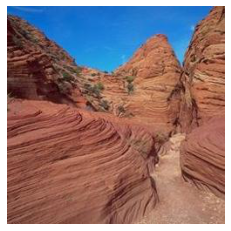

This image is  0.00 percent Fire  and   100.00 percent Non Fire.


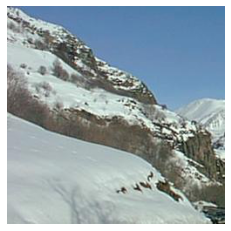

In [26]:
#evaluate model visually
test_fire_direc = "../Data/Dataset_split/test/Data_Fire/"
test_nonfire_direc = "../Data/Dataset_split/test/Data_NonFire/"
#plots images 
import matplotlib.image as mpimg
def plot_image_inference(direc, model):
    for x in range(0,10):
        img = keras.preprocessing.image.load_img(
                direc+os.listdir(direc)[x], target_size=(img_height, img_width)
        )
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)  # Create batch axis

        predictions = model.predict(img_array)
        score = predictions[0]
        print(
            "This image is \033[1m %.2f percent Fire \033[0m and  \033[1m %.2f percent Non Fire."
            % (100 * (1 - score), 100 * score)
        )
        img = mpimg.imread(direc+os.listdir(direc)[x])
        imgplot = plt.imshow(img)
        plt.axis("off")
        plt.show()
print("\033[1m--------------------------------  FIRE IMAGES  --------------------------------\033[0m")
plot_image_inference(test_fire_direc, best_model)
print("\033[1m--------------------------------  NON FIRE IMAGES  --------------------------------\033[0m")
plot_image_inference(test_nonfire_direc, best_model)

In [34]:
# evaluate the model
loss, accuracy, auc, f1_score, precision, recall = model_3.evaluate(test_ds, verbose=0)
print(f"Validation on Validation Data:\nAccuracy: {round(accuracy,3)}\nAUC: {round(auc,3)}\nF1: {round(f1_score,3)}\nPrecision: {round(precision,3)}\nRecall:{round(recall,3)}")

Validation on Validation Data:
Accuracy: 0.963
AUC: 0.995
F1: 0.964
Precision: 0.944
Recall:0.987


## Conclusion

In this project, we trained a Convolutional Neural Network on Images with and without Forest Fires. Our final F1 Score on the test data set was 0,964. An additional visual test on 20 images proofed the model to be confident in its classification decisions. We suggest the model to be further tested in the field.

## References 
*   https://www.tensorflow.org/tutorials/images/classification
*   https://keras.io/examples/vision/image_classification_from_scratch/



